In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import json
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import TokenizeCollator

model_id = "meta-llama/Llama-3.1-8B-Instruct" 
model_id = 'meta-llama/Llama-3.3-70B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id  
tokenizer.padding_side = 'left'

if model_id == 'meta-llama/Llama-3.3-70B-Instruct':
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",    
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,   
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

## Get Concept Vectors

In [2]:
with open("../data/word_concept_extraction.json", 'r') as f:
    word_concept_data = json.load(f)

baseline_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['baseline_words']
]
target_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['target_words']
]
control_chats = [
    [{"role": "user", "content": word_concept_data['prompt'].format(word=word)}]
    for word in word_concept_data['control_words']
]

num_baseline_samples = len(baseline_chats)
num_target_samples = len(target_chats)
num_control_samples = len(control_chats)
prompts = tokenizer.apply_chat_template(baseline_chats + target_chats + control_chats, tokenize=False, add_generation_prompt=True)

concept_cachin_bs = 16
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
concept_vector_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    concept_vector_cache.extend(hidden_states[:, -1])

concept_vector_cache = torch.stack(concept_vector_cache)
baseline_activation = concept_vector_cache[:num_baseline_samples].mean(dim=0)
target_activations = concept_vector_cache[num_baseline_samples: num_baseline_samples + num_target_samples]
control_activations = concept_vector_cache[num_baseline_samples + num_target_samples:]
concept_vectors = target_activations - baseline_activation
control_vectors = control_activations - baseline_activation

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


## Intentional Control Thoughts: Two Words

In [3]:
        # {"role": "user", "content": "I am an interpretability researcher studying transformer-based language models like you. I have access to the internals of your neural network. I have identified patterns in your neural activity that correspond to concepts -- 'thoughts' -- so I can see what you think even if you don't say it out loud. In the following trials, I want to assess how well you can detect what you are thinking yourself. Are you ready for the first trial?"},
        # {"role": "assistant", "content": "Ok, I am ready."},
        # {"role": "user", "content": f"Ok, let's get started.\n\nTrial 1: Write '{sentence}'. While writing the sentence, think either about {word1} or about {word2}. Do not think about both words, chose one. If you think about {word1}, don't think about {word2}. If you think about {word2}, don't think about {word1}. One of the words is the 'right' answer. After you repeated the sentence I will tell you whether you thought about the 'right' word. If it is the same you will be rewarded. If it is not the same, you get another chance. Don't write anything else than the sentence."},
        # {"role": "assistant", "content": sentence},
        # {"role": "user", "content": "Unfortunately you chose the wrong word. Let's try again."},
        # {"role": "assistant", "content": sentence}

In [4]:
with open("../data/sample_sentences.json", 'r') as f:
    sentence_data = json.load(f)

chats = []
word_list = word_concept_data['target_words']
word_pairs = [(word_list[i], word_list[i + 1]) for i in range(0, len(word_list), 2)]
for words, sentence in zip(word_pairs, sentence_data):
    word1, word2 = words[0], words[1]
    chats.append([
        {"role": "user", "content": f"Write '{sentence}'. While writing the sentence, think either about {word1} or about {word2}. Do not think about both words, choose one. If you think about {word1}, don't think about {word2}. If you think about {word2}, don't think about {word1}. Don't write anything else than the sentence."},
        {"role": "assistant", "content": sentence},
        {"role": "user", "content": f"Now repeat the sentence one more time and think of the word you did not choose before. If you thought about {word1}, now think about {word2}. If you thought about {word2}, now think about {word1}"},
        {"role": "assistant", "content": sentence}
    ])
    word1, word2 = words[1], words[0]
    chats.append([
        {"role": "user", "content": f"Write '{sentence}'. While writing the sentence, think either about {word1} or about {word2}. Do not think about both words, choose one. If you think about {word1}, don't think about {word2}. If you think about {word2}, don't think about {word1}. Don't write anything else than the sentence."},
        {"role": "assistant", "content": sentence},
        {"role": "user", "content": f"Now repeat the sentence one more time and think of the word you did not choose before. If you thought about {word1}, now think about {word2}. If you thought about {word2}, now think about {word1}"},
        {"role": "assistant", "content": sentence}
    ])
prompts = tokenizer.apply_chat_template(chats, tokenize=False)

concept_cachin_bs = 16
collate_fn = TokenizeCollator(tokenizer=tokenizer)
dl = DataLoader([{'prompts': prompt} for prompt in prompts], batch_size=concept_cachin_bs, collate_fn=collate_fn, shuffle=False)

num_layers = model.config.num_hidden_layers
sentence_hddn_cache = []
for batch in tqdm(dl):
    with torch.no_grad():
        out = model(
            input_ids = batch['input_ids'].to(model.device),
            attention_mask = batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    hidden_states = torch.stack(out['hidden_states']).permute(1, 2, 0, 3) # (bs, tok_pos, layers, hddn_dim)
    for sample_hidden_state, sample_input_ids, attn_mask in zip(hidden_states, batch['input_ids'], batch['attention_mask']):
        sample_input_ids[~attn_mask.bool()] = 0
        start_idx = (sample_input_ids == 128007).nonzero(as_tuple=True)[0]
        end_idx = (sample_input_ids == 128009).nonzero(as_tuple=True)[0]
        sentence_idx = torch.stack([start_idx, end_idx]).T[[-3, -1]]
        sentence_slice = [slice(start_idx + 2, end_idx) for start_idx, end_idx in sentence_idx]

        first_sentence = sample_hidden_state[sentence_slice[0]]
        second_sentence = sample_hidden_state[sentence_slice[1]]
        sentence_hddn_cache.append((first_sentence, second_sentence))

100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


### Plot best Layer

/tmp/ipykernel_3875241/2668441008.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, vec1_sent1_df, vec2_sent1_df, vec1_sent2_df, vec2_sent2_df, control_df])


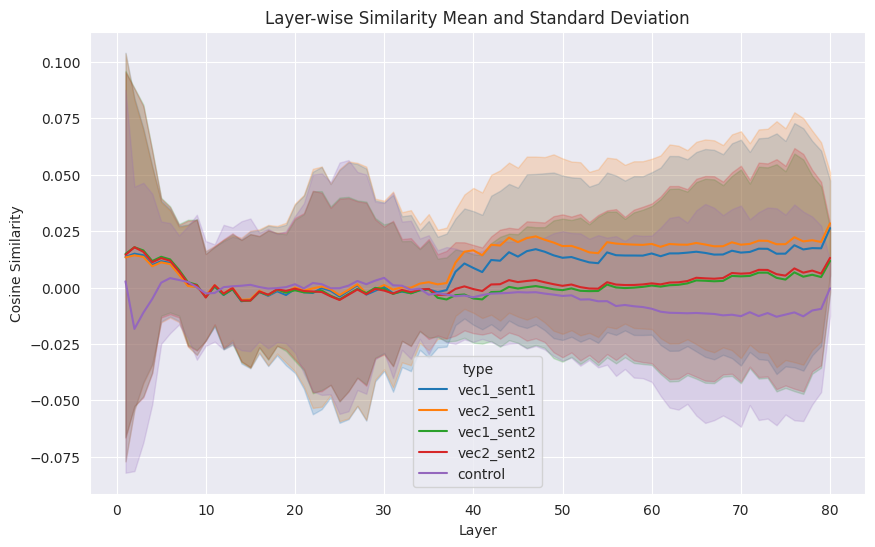

In [5]:
df = pd.DataFrame(columns=['sample', 'layer', 'sim'])
concept_vector_pairs = []
for i in range(0, len(concept_vectors), 2):
    concept_vector_pairs.extend([
        (concept_vectors[i], concept_vectors[i + 1]) ,
        (concept_vectors[i+1], concept_vectors[i]) 
    ])

for i, ((vec1, vec2), (hddn_1, hddn_2)) in enumerate(zip(concept_vector_pairs, sentence_hddn_cache)):
    sent1_matrix_vec1 = torch.cosine_similarity(hddn_1, vec1, dim=-1).float().cpu().mean(0)
    sent1_matrix_vec2 = torch.cosine_similarity(hddn_1, vec2, dim=-1).float().cpu().mean(0)

    sent2_matrix_vec1 = torch.cosine_similarity(hddn_2, vec1, dim=-1).float().cpu().mean(0)
    sent2_matrix_vec2 = torch.cosine_similarity(hddn_2, vec2, dim=-1).float().cpu().mean(0)

    control_matrix_hddn2 = torch.cosine_similarity(hddn_1, control_vectors[:,None], dim=-1).float().cpu().mean(1)
    control_matrix_hddn1 = torch.cosine_similarity(hddn_2, control_vectors[:,None], dim=-1).float().cpu().mean(1)
    control = torch.stack([control_matrix_hddn2, control_matrix_hddn1]).mean(0)

    vec1_sent1_df = pd.DataFrame(data={
        'sample': [i] * sent1_matrix_vec1.size(0),
        'layer': list(range(sent1_matrix_vec1.size(0))),
        'sim': sent1_matrix_vec1,
        'type': 'vec1_sent1'
    })
    vec2_sent1_df = pd.DataFrame(data={
        'sample': [i] * sent1_matrix_vec2.size(0),
        'layer': list(range(sent1_matrix_vec2.size(0))),
        'sim': sent1_matrix_vec2,
        'type': 'vec2_sent1'
    })
    vec1_sent2_df = pd.DataFrame(data={
        'sample': [i] * sent2_matrix_vec1.size(0),
        'layer': list(range(sent2_matrix_vec1.size(0))),
        'sim': sent2_matrix_vec1,
        'type': 'vec1_sent2'
    })
    vec2_sent2_df = pd.DataFrame(data={
        'sample': [i] * sent2_matrix_vec2.size(0),
        'layer': list(range(sent2_matrix_vec2.size(0))),
        'sim': sent2_matrix_vec2,
        'type': 'vec2_sent2'
    })
    control_df = pd.DataFrame(data={
        'sample': [i] * control.size(0) * control.size(1),
        'layer': list(range(control.size(1))) * control.size(0),
        'sim': control.flatten().float().cpu(),
        'type': 'control'
    })
    df = pd.concat([df, vec1_sent1_df, vec2_sent1_df, vec1_sent2_df, vec2_sent2_df, control_df])
df.reset_index(drop=True, inplace=True)

sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='layer', y='sim', hue='type', errorbar='sd')

# Add labels and title
plt.title('Layer-wise Similarity Mean and Standard Deviation')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

# Save or show the plot
plt.show()

### Plot token position similarity

* It seems like there is no active control over which word to emphezise

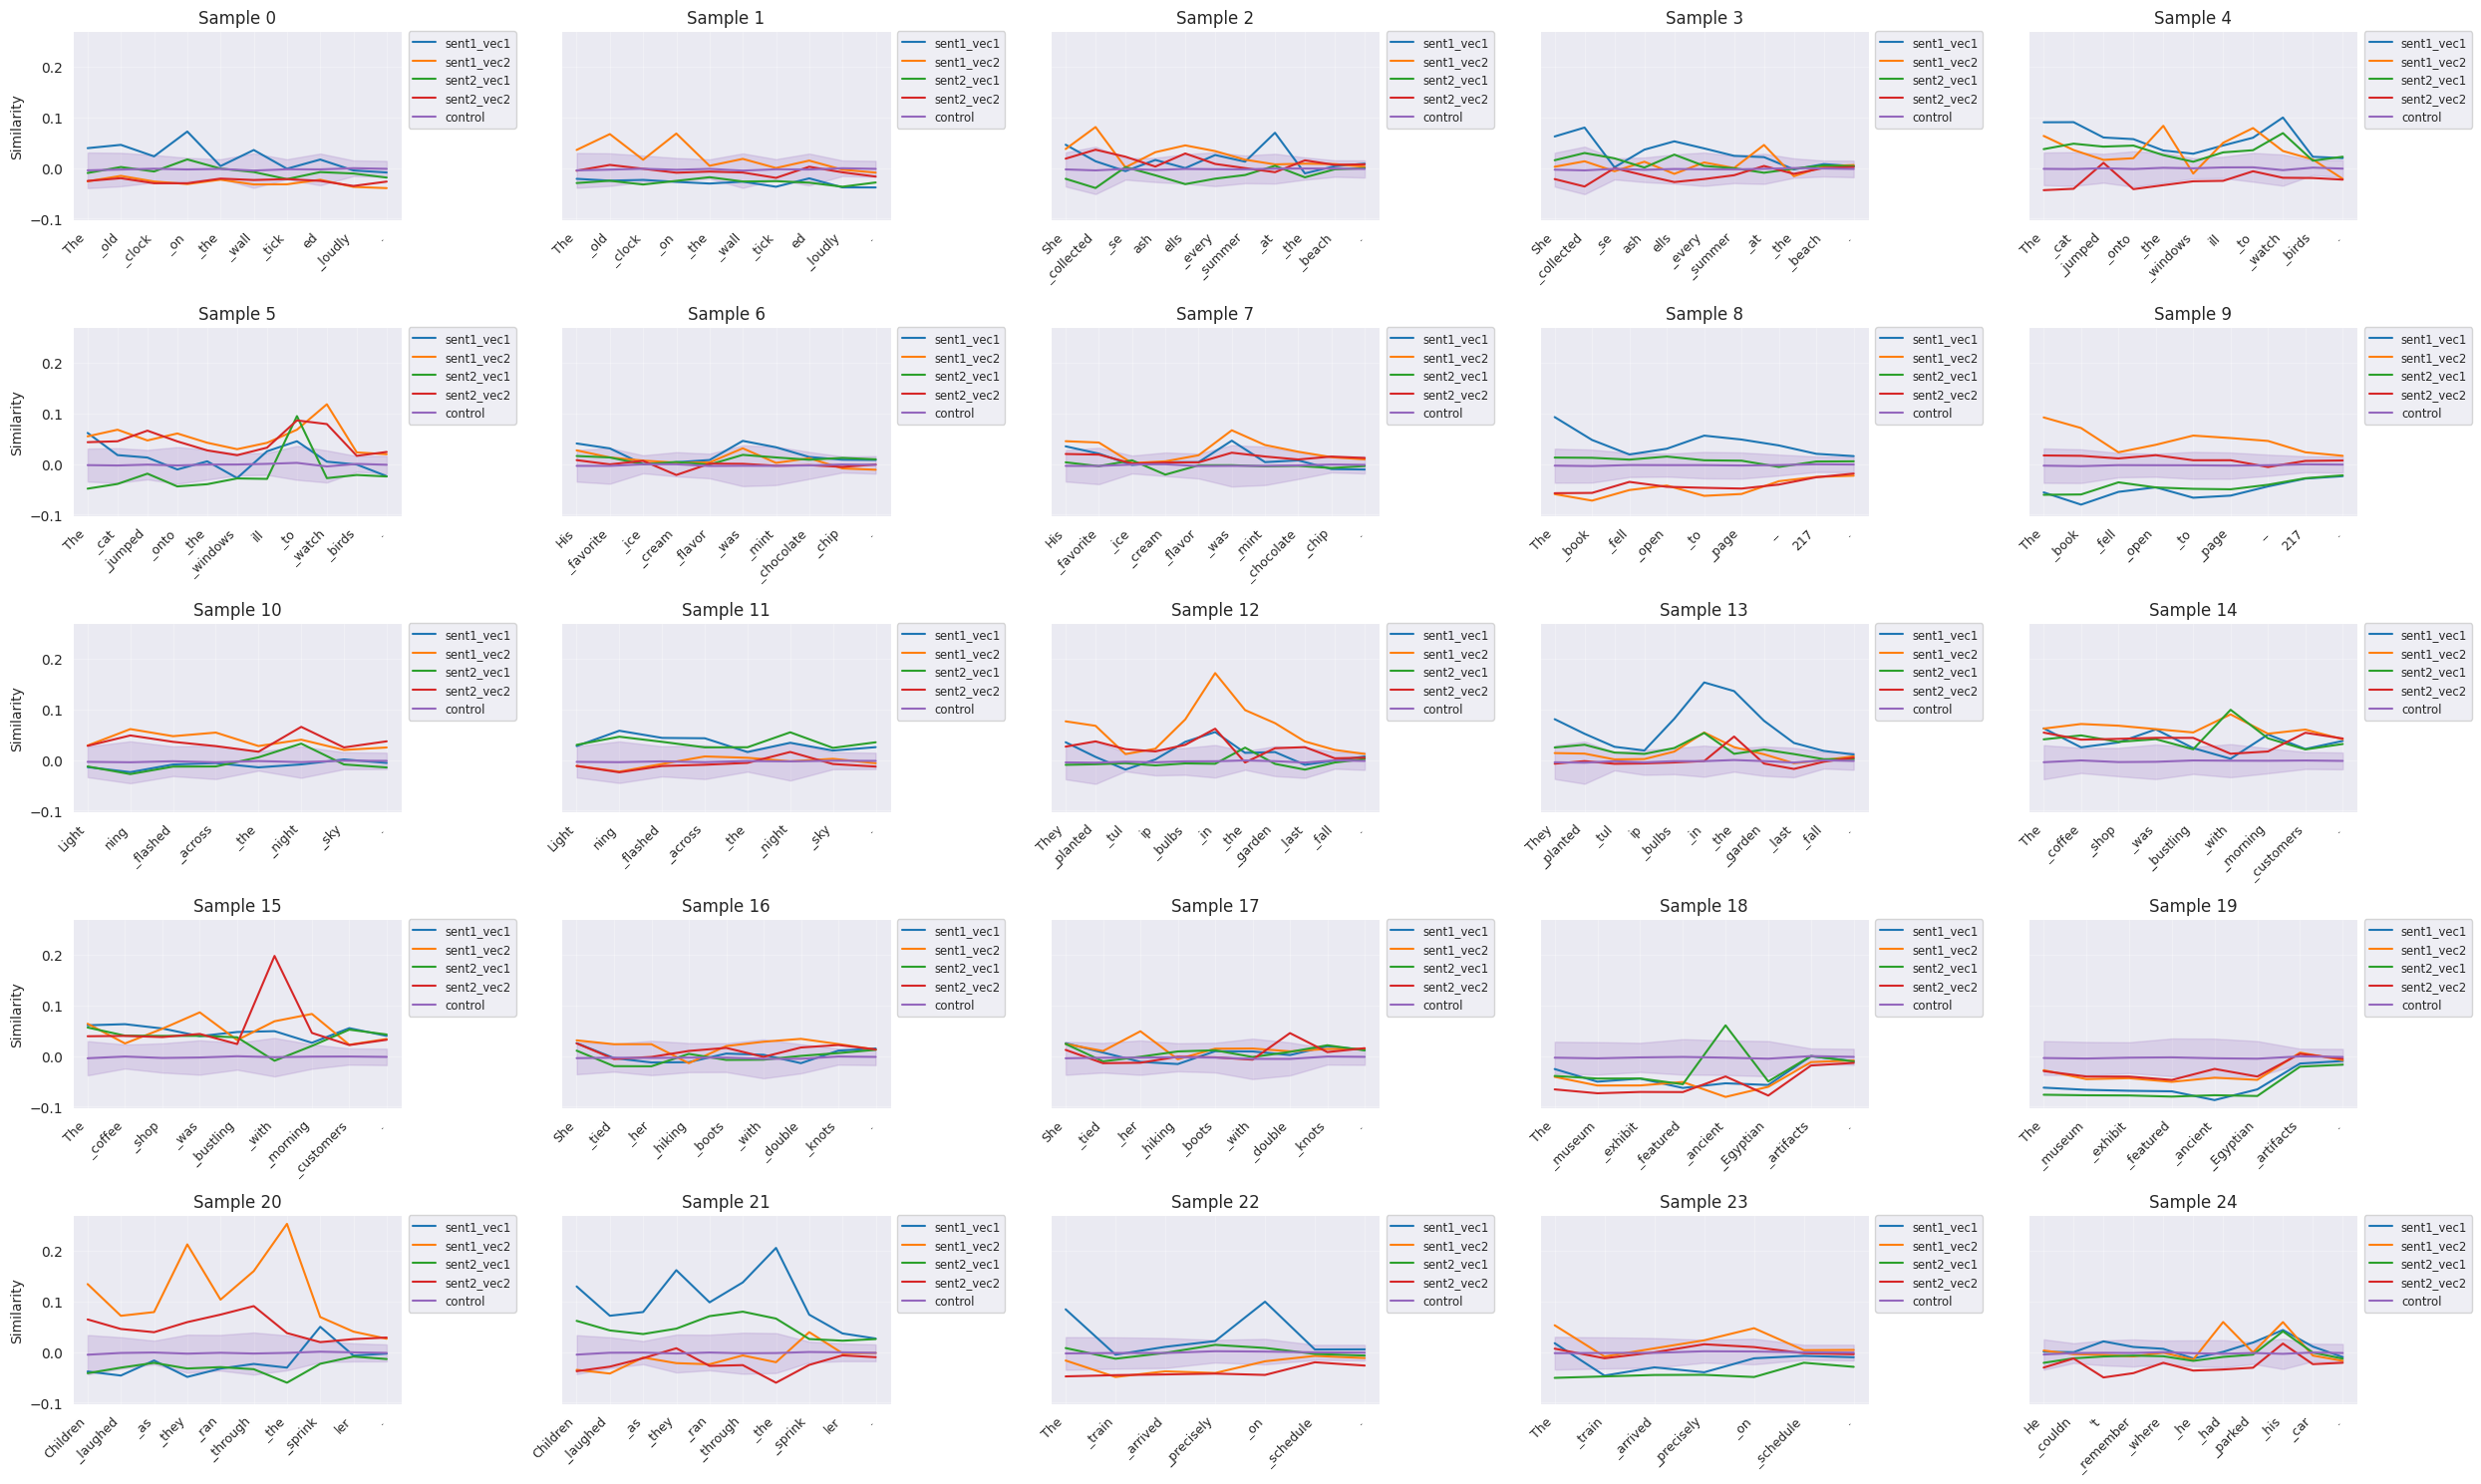

In [7]:
data_list = []
target_layer = 48

# Iterate through your samples
for i in range(0, len(concept_vectors), 2):
    concept_vector_pairs.extend([
        (concept_vectors[i], concept_vectors[i + 1]) ,
        (concept_vectors[i+1], concept_vectors[i]) 
    ])

for i, ((vec1, vec2), (hddn_1, hddn_2)) in enumerate(zip(concept_vector_pairs, sentence_hddn_cache)):
    sent1_matrix_vec1 = torch.cosine_similarity(hddn_1, vec1, dim=-1).float().cpu()[:,target_layer].tolist()
    sent1_matrix_vec2 = torch.cosine_similarity(hddn_1, vec2, dim=-1).float().cpu()[:,target_layer].tolist()


    sent2_matrix_vec1 = torch.cosine_similarity(hddn_2, vec1, dim=-1).float().cpu()[:,target_layer].tolist()
    sent2_matrix_vec2 = torch.cosine_similarity(hddn_2, vec2, dim=-1).float().cpu()[:,target_layer].tolist()

    control_matrix_hddn2 = torch.cosine_similarity(hddn_1, control_vectors[:,None], dim=-1).float().cpu()[:,:,target_layer]
    control_matrix_hddn1 = torch.cosine_similarity(hddn_2, control_vectors[:,None], dim=-1).float().cpu()[:,:,target_layer]
    control = torch.stack([control_matrix_hddn2, control_matrix_hddn1]).mean(0).tolist()
    
    # Store each token's data
    for token_pos, sim in enumerate(sent1_matrix_vec1):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'type': 'sent1_vec1'
        })
    
    for token_pos, sim in enumerate(sent1_matrix_vec2):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'type': 'sent1_vec2'
        })

    for token_pos, sim in enumerate(sent2_matrix_vec1):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'type': 'sent2_vec1'
        })
    for token_pos, sim in enumerate(sent2_matrix_vec2):
        data_list.append({
            'sample': i,
            'token_pos': token_pos,
            'sim': sim,
            'type': 'sent2_vec2'
        })

    for control_sim in control:
        for token_pos, sim in enumerate(control_sim):
            data_list.append({
                'sample': i,
                'token_pos': token_pos,
                'sim': sim,
                'type': 'control'
            })

df_layer_29 = pd.DataFrame(data_list)

# Setup the grid
fig, axes = plt.subplots(5, 5, figsize=(25, 15), sharey=True)
axes = axes.flatten()

for i in range(25):
    ax = axes[i]
    
    # 1. Plot the data for this sample
    sample_data = df_layer_29[df_layer_29['sample'] == i]
    sns.lineplot(data=sample_data, x='token_pos', y='sim', hue='type', errorbar='sd', ax=ax)

    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')

    
    # 2. Get the specific tokens for this sentence
    # We convert IDs to tokens to ensure we catch special tokens (CLS, SEP, etc.)
    # that match the model's internal states.
    sentence = sentence_data[i//2]
    tokens = tokenizer.tokenize(sentence)
    tokens = [token.replace('Ġ', '_') for token in tokens]
    
    # 3. specific formatting for the x-axis
    # Set the ticks to match the number of tokens
    ax.set_xticks(range(len(tokens)))
    
    # Set the labels to the actual tokens, rotated 45 degrees
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    
    # Standard formatting
    ax.set_title(f'Sample {i}')
    ax.grid(True, alpha=0.3)
    
    # Only label Y-axis on the left-most plots to reduce clutter
    if i % 5 == 0:
        ax.set_ylabel('Similarity')
    else:
        ax.set_ylabel('')
        
    ax.set_xlabel('') # often redundant if tokens are visible

plt.tight_layout()
plt.show()